In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Regularized Word Embeddings in Text Classification and in Ad-hoc IR
## 4. Document Representations

We consider three document representations:

- Vector Space Model (VSM)
- Soft Vector Space Model (Soft VSM)
- Latent Semantic Indexing (LSI)

We consider four term weighting schemes:

- Binary
- Bag of Words (BOW)
- TF-IDF
- Okapi BM25

And we consider two similarities:

- Inner Product (IP)
- Word Mover's Distance (WMD)

## 6. Evaluation

Not all combinations of document representations, term weighting schemes, and similarities are evaluated:

| ↓ Weights, Space and similarity → | VSM IP | VSM WMD | Soft VSM IP | LSI IP |
|--|--|--|--|--|
| Binary | ❌ | ❌ | ✅<sup>2</sup>  | ❌ |
| BOW | ✅ | ✅ | ✅<sup>1, 2</sup> | ❌ |
| TF-IDF | ✅ | ❌ | ✅ | ✅ |
| Okapi BM25 | ✅ | ❌ | ❌ | ❌ |

<sup>1</sup> We use non-normalized BOW queries, $L_1$-normalized BOW collection documents, and the non-normalized inner product.  
<sup>2</sup> We only use the dense soft VSM. 

In [2]:
configurations = [
    ('vsm', 'bow', 'inner_product', 32),
    ('vsm', 'tfidf', 'inner_product', 32),
    ('vsm', 'bm25', 'inner_product', 32),
    ('lsi', 'tfidf', 'inner_product', 32),
#    ('dense_soft_vsm', 'tfidf', 'inner_product', 32),
#    ('dense_soft_vsm', 'tfidf', 'inner_product', 1),
#    ('dense_soft_vsm', 'bow', 'inner_product', 1),
#    ('dense_soft_vsm', 'bow', 'inner_product', 32),
#    ('dense_soft_vsm', 'binary', 'inner_product', 32),
#    ('dense_soft_vsm', 'binary', 'inner_product', 1),
#    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32),
#    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1),
#    ('vsm', 'bow', 'wmd', 32),
#    ('vsm', 'bow', 'wmd', 1),
]
configuration_names = {
    ('vsm', 'bow', 'inner_product', 32): 'BOW',
    ('vsm', 'tfidf', 'inner_product', 32): 'TF-IDF',
    ('vsm', 'bm25', 'inner_product', 32): 'Okapi BM25',
    ('lsi', 'tfidf', 'inner_product', 32): 'LSI',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32): 'Dense SCM (32b)',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1): 'Dense SCM (1b)',
    ('dense_soft_vsm', 'bow', 'inner_product', 32): 'NTLM (32b)',
    ('dense_soft_vsm', 'bow', 'inner_product', 1): 'NTML (1b)',
    ('dense_soft_vsm', 'binary', 'inner_product', 32): 'NQE (32b)',
    ('dense_soft_vsm', 'binary', 'inner_product', 1): 'NQE (1b)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32): 'Sparse SCM (32b)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1): 'Sparse SCM (1b)',
    ('vsm', 'bow', 'wmd', 32): 'WMD (32b)',
    ('vsm', 'bow', 'wmd', 1): 'WMD (1b)',
}

There are several parameters that are tuned by grid search.

- Soft VSM (sparse):
    - `symmetric`${}\in\{$ `True`, `False` $\}$
    - `positive_definite`${}\in\{$ `True`, `False` $\}$
    - `tfidf`${}\in\{$ `<TfidfModel>`, `None` $\}$
    - `nonzero_limit`${}\in\{100, 200, \ldots, 600\}$
- TFIDF:
    - `slope`${}\in\{0.0, 0.1, \ldots, 1.0\}$
- Okapi BM25:
    - $k_1\in\{1.2, 1.3, \ldots, 2.0\}$

   
### 6.1 Datasets


In [3]:
from common import ClassificationResult

dataset_names = []
results = dict()


def load_results(name, dataset_loader):
    """Loads classification results for a given dataset.
    
    Parameters
    ----------
    name : str
        The name of a dataset.
    dataset_loader : callable
        Loads training, validation, and test sets from the dataset.
    """

    dataset_names.append(name)
    results[name] = dict()
    datasets = None
    for configuration in configurations:
        basename = '{}-{}'.format(name, '-'.join(map(str, configuration)))
        try:
            results[name][configuration] = ClassificationResult.from_file(basename)
        except IOError:
            if datasets is None:
                datasets = dataset_loader()
            train, validation, test = datasets
            result = train.classify(validation, test, *configuration)
            result.to_file(basename)
            results[name][configuration] = result

2019-02-01 05:55:00,548 : INFO : 'pattern' package not found; tag filters are not available for English



For classification, we use the following datasets:

- [20 Newsgroups][] (1995, 14M, 18.83k documents, *free*)

 [20 Newsgroups]: http://qwone.com/~jason/20Newsgroups/ (Home Page for 20 Newsgroups Data Set)

In [4]:
from common import load_newsgroups

load_results('newsgroups', load_newsgroups)

2019-02-01 05:55:00,860 : INFO : Loading a classification result from file results/classification-newsgroups-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:00,865 : INFO : Loading a classification result from file results/classification-newsgroups-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:00,868 : INFO : Loading a classification result from file results/classification-newsgroups-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:00,876 : INFO : Loading a classification result from file results/classification-newsgroups-lsi-tfidf-inner_product-32.pkl.xz.



- [AMAZON][] (2015, 20G, 142.8m documents, *free*)
    - For computational efficiency, we subsample the dataset using four of the 24 product categories.
    - For computational efficiency, we subsample the dataset using only 1 out of every 100 review texts.

 [AMAZON]: http://jmcauley.ucsd.edu/data/amazon/ (Amazon review data)


In [5]:
from common import load_amazon

load_results('amazon', load_amazon)  # Not yet computed.

2019-02-01 05:55:00,942 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:00,944 : INFO : Loading a classification result from file results/classification-amazon-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:00,945 : INFO : Loading a classification result from file results/classification-amazon-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:00,947 : INFO : Loading a classification result from file results/classification-amazon-lsi-tfidf-inner_product-32.pkl.xz.



- [BBC] (2005, 864K, 2.23k documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [6]:
from common import load_bbc

load_results('bbc', load_bbc)  # Not yet computed.

2019-02-01 05:55:01,010 : INFO : Loading a classification result from file results/classification-bbc-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:01,013 : INFO : Loading a classification result from file results/classification-bbc-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:01,016 : INFO : Loading a classification result from file results/classification-bbc-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:01,018 : INFO : Loading a classification result from file results/classification-bbc-lsi-tfidf-inner_product-32.pkl.xz.



- [BBCSport][BBC] (2005, 255K, 737 documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [7]:
from common import load_bbcsport

load_results('bbcsport', load_bbcsport)  # Not yet computed.

2019-02-01 05:55:01,089 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:01,091 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:01,092 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:01,094 : INFO : Loading a classification result from file results/classification-bbcsport-lsi-tfidf-inner_product-32.pkl.xz.



- [OHSUMED][] (1994, 24M, 50.22k documents, *free*)

 [OHSUMED]: http://disi.unitn.it/moschitti/corpora.htm (Donwloadable Corpora)


In [8]:
from common import load_ohsumed

load_results('ohsumed', load_ohsumed)  # Not yet computed.

2019-02-01 05:55:01,138 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:01,139 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:01,140 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:01,142 : INFO : Loading a classification result from file results/classification-ohsumed-lsi-tfidf-inner_product-32.pkl.xz.



- [Reuters-21578][] (1987, 8.2M, 215.78k documents, *free*)

 [Reuters-21578]: http://www.daviddlewis.com/resources/testcollections/reuters21578/ (Reuters-21578 Text Categorization Test Collection)

In [9]:
from common import load_reuters

load_results('reuters', load_reuters)  # Not yet computed.

2019-02-01 05:55:01,203 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:01,208 : INFO : Loading a classification result from file results/classification-reuters-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:01,213 : INFO : Loading a classification result from file results/classification-reuters-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:01,218 : INFO : Loading a classification result from file results/classification-reuters-lsi-tfidf-inner_product-32.pkl.xz.


- [TWITTER][] (2011, 160K, 6.4k documents, *free*)

 [TWITTER]: https://web.archive.org/web/20180328044709/www.sananalytics.com/lab/twitter-sentiment/ (Sanders Analytics - Twitter Sentiment Corpus)

In [10]:
from common import load_twitter

load_results('twitter', load_twitter)  # Not yet computed.

2019-02-01 05:55:01,278 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-inner_product-32.pkl.xz.
2019-02-01 05:55:01,280 : INFO : Loading a classification result from file results/classification-twitter-vsm-tfidf-inner_product-32.pkl.xz.
2019-02-01 05:55:01,282 : INFO : Loading a classification result from file results/classification-twitter-vsm-bm25-inner_product-32.pkl.xz.
2019-02-01 05:55:01,283 : INFO : Loading a classification result from file results/classification-twitter-lsi-tfidf-inner_product-32.pkl.xz.



### 6.3 Classification

We compare the individual document representations, term weighing schemes, and similarities using $k$NN on standard datasets. In addition to the above parameters, we also tune $k\in\{1,2,\ldots,19\}$.

## 7. Results
 
Useful links:

- [Monochrome (Black & white) plots in matplotlib](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)
- [Add confidence interval on barplot](https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/)

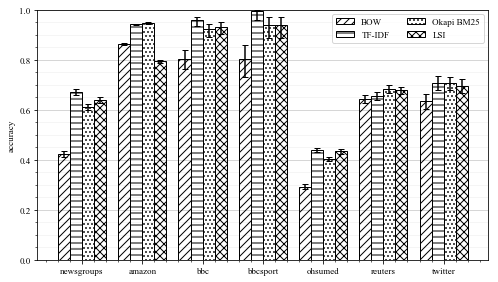

In [11]:
%matplotlib inline

from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

num_bars = len(configurations)
bar_width = 1.0 / (num_bars + 1)
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            results[name][configuration].accuracy()[0],
            results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1],
            results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0],
        )
        for name in dataset_names
    )
    for configuration in configurations
))))
bar_xs = [
    np.arange(len(dataset_names)) + bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]
hatches = ('///', '--', '...', 'xxx', '\///', '\\\\', '*', 'o')

rcParams['font.size'] = 9
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'TeX Gyre Termes']

plt.figure(figsize=(7, 4))
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', hatch=hatch, yerr=yerr, capsize=3, label=label)
plt.xticks(bar_xs[num_bars // 2] - 0.5 * bar_width, dataset_names)
plt.minorticks_on()
plt.ylabel('accuracy')
plt.ylim((0.0, 1.0))
plt.legend(loc='upper right', ncol=2)
plt.grid(axis='y', which='major', color='k', alpha=0.2)
plt.grid(axis='y', which='minor', color='k', alpha=0.05)
plt.tight_layout()
plt.savefig('classification.pdf')
plt.show()